In [1]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = "C:\\AData\\kuliah\\sem 7\\Tugas Akhir\\Kode Program\\data gabungan aod cuaca pm2.5\\jakarta_gbk.csv"
df_cleaned = pd.read_csv(path)
columns = ['ISPU PM2.5', 'temp', 'dew', 'humidity', 'windspeed', 'AOD'] # untuk nilai 0
for col in columns:
    df_cleaned.loc[df_cleaned[col] == 0, col] = pd.NA
    
df_cleaned.replace("-", pd.NA, inplace=True)

columns = ['ISPU PM2.5', 'temp', 'dew', 'humidity', 'windspeed', 'precip', 'AOD'] # untuk interpolasi
for col in columns:
    df_cleaned[col] = df_cleaned[col].interpolate(method='linear')

df_cleaned = df_cleaned.dropna()

In [3]:
df_cleaned

,ISPU PM2.5,datetime,temp,dew,humidity,precip,windspeed,AOD
6,71.117647,2022-01-07,28.0,23.7,79.4,0.615,17.6,0.05280
7,57.545455,2022-01-08,28.4,24.2,79.5,0.027,20.9,0.04800
8,71.666667,2022-01-09,28.7,24.4,78.1,0.000,25.2,0.14125
9,65.444444,2022-01-10,27.9,24.6,82.8,11.327,19.8,0.23450
10,59.222222,2022-01-11,26.6,24.4,88.8,59.072,17.2,0.32775
...,...,...,...,...,...,...,...,...
1091,63.500000,2024-12-27,29.0,23.5,73.6,0.000,17.5,0.02000
1092,63.500000,2024-12-28,29.6,22.6,67.5,0.003,20.6,1.81460
1093,63.500000,2024-12-29,29.1,23.8,73.8,0.028,15.4,1.26630
1094,63.500000,2024-12-30,28.1,23.2,75.5,1.455,29.0,0.71800


In [4]:
df = df_cleaned

features = ["temp", "dew", "humidity", "precip", "windspeed", "AOD", "ISPU PM2.5"]
target = "ISPU PM2.5"

# Normalisasi data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Tentukan lookback (jumlah timestep sebelumnya digunakan untuk prediksi)
lookback = 30

# Bagi data menjadi training (70%), validasi (15%), dan testing (15%)
train_size = int(len(df_scaled) * 0.7)
val_size = int(len(df_scaled) * 0.15)

train_data = df_scaled[:train_size]
val_data = df_scaled[train_size:train_size+val_size]
test_data = df_scaled[train_size+val_size:]

# Gunakan TimeseriesGenerator untuk membentuk data dalam format sekuensial
train_gen = TimeseriesGenerator(train_data, train_data[:, 6], length=lookback, batch_size=4)
val_gen = TimeseriesGenerator(val_data, val_data[:, 6], length=lookback, batch_size=4)
test_gen = TimeseriesGenerator(test_data, test_data[:, 6], length=lookback, batch_size=4)

# Cek bentuk data generator
len(train_gen), len(val_gen), len(test_gen)

(184, 34, 34)

In [7]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import Callback
import numpy as np

def build_lstm_model(input_shape, lstm_units, optimizer, learning_rate):
    model = Sequential([
        Input(shape=input_shape),
        LSTM(lstm_units, activation='relu', return_sequences=True),
        Dropout(0.2),
        LSTM(lstm_units, activation='relu', return_sequences=False),
        Dropout(0.2),
        Dense(25, activation='relu'),
        Dense(1)
    ])
    
    opt = Adam(learning_rate=learning_rate) if optimizer == 'adam' else RMSprop(learning_rate=learning_rate)
    model.compile(optimizer=opt, loss='mse')
    return model

def evaluate_model(model, test_gen):
    test_pred = model.predict(test_gen)
    
    test_true_list = []
    for i in range(len(test_gen)):  
        _, y = test_gen[i]  # Ambil hanya nilai target dari generator
        test_true_list.append(y)
    
    test_true = np.hstack(test_true_list)  # Gabungkan list ke array numpy
    
    test_r2 = r2_score(test_true, test_pred)
    test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
    test_mbe = np.mean(test_true - test_pred)
    test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))
    
    return {'R2': test_r2, 'RMSE': test_rmse, 'MBE': test_mbe, 'NSE': test_nse}

def grid_search_lstm(train_gen, val_gen, test_gen, input_shape, param_grid):
    results = []
    models = {}
    all_history = {}
    all_r2_callback = {}
    for epochs in param_grid['epochs']:
        for learning_rate in param_grid['learning_rate']:
            for optimizer in param_grid['optimizer']:
                for lstm_units in param_grid['lstm_units']:
                    class R2History(Callback):
                        def __init__(self, val_gen):
                            self.val_gen = val_gen
                            self.r2_scores = []
                    
                        def on_epoch_end(self, epoch, logs=None):
                            val_pred = self.model.predict(self.val_gen, verbose=0)
                    
                            val_true_list = []
                            for i in range(len(test_gen)):  
                                _, y =  val_gen[i]  # Ambil hanya nilai target dari generator
                                val_true_list.append(y)
                            
                            val_true = np.hstack(val_true_list)  # Gabungkan list ke array numpy
                                            
                            r2 = r2_score(val_true, val_pred)
                            self.r2_scores.append(r2)
                            
                    r2_callback = R2History(val_gen)
                    config_name = f"epochs_{epochs}_lr_{learning_rate}_opt_{optimizer}_units_{lstm_units}"
                    print(f"\nTraining model dengan {config_name}")
                    
                    model = build_lstm_model(input_shape, lstm_units, optimizer, learning_rate)
                    history = model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=0,callbacks=[r2_callback])
                    
                    history = model.fit(train_gen, validation_data=val_gen, epochs=epochs, verbose=0,callbacks=[r2_callback])
                    
                    metrics = evaluate_model(model, test_gen)
                    print(metrics)
                    
                    results.append({
                        'epochs': epochs,
                        'learning_rate': learning_rate,
                        'optimizer': optimizer,
                        'lstm_units': lstm_units,
                        'R2': metrics['R2'],
                        'RMSE': metrics['RMSE'],
                        'MBE': metrics['MBE'],
                        'NSE': metrics['NSE']
                    })
                    models[config_name] = model
                    all_history[config_name] = history
                    all_r2_callback[config_name] = r2_callback
    
    return results, models, all_history, all_r2_callback

In [8]:
param_grid = {
    'epochs': [100],
    'learning_rate': [0.0001, 0.001, 0.01],
    'optimizer': ['adam', 'rmsprop'],
    'lstm_units': [16, 32, 64]
}


grid_results, models, all_history, all_r2_callback = grid_search_lstm(train_gen, val_gen, test_gen, (lookback, len(features)), param_grid)

df_results = pd.DataFrame(grid_results)


Training model dengan epochs_100_lr_0.0001_opt_adam_units_16


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 1/34 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'R2': -7.09260317847232e+29, 'RMSE': np.float64(0.04675015609826504), 'MBE': np.float64(0.04628440312306176), 'NSE': np.float64(-9.50408825915291e+31)}

Training model dengan epochs_100_lr_0.0001_opt_adam_units_32
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
{'R2': -2.508402738978947e+29, 'RMSE': np.float64(0.027802181058564492), 'MBE': np.float64(0.02088988402707156), 'NSE': np.float64(-3.3612596702317894e+31)}

Training model dengan epochs_100_lr_0.0001_opt_adam_units_64
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'R2': -1.4344936949349031e+29, 'RMSE': np.float64(0.02102468782021676), 'MBE': np.float64(0.013933869856496065), 'NSE': np.float64(-1.9222215512127698e+31)}

Training model dengan epochs_100_lr_0.0001_opt_rmsprop_units_16
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
{'R2': -8.485434681376552e+29, 'RMSE': np.float64(0.05113488475630712), 'MBE': np.float64(0.05100526135180217), 'NSE': np.float64(-1.1370482473044577e+32)}

Training model dengan epochs_1

In [9]:
df_results

,epochs,learning_rate,optimizer,lstm_units,R2,RMSE,MBE,NSE
0,100,0.0001,adam,16,-7.092603e+29,0.046750,0.046284,-9.504088e+31
1,100,0.0001,adam,32,-2.508403e+29,0.027802,0.020890,-3.361260e+31
2,100,0.0001,adam,64,-1.434494e+29,0.021025,0.013934,-1.922222e+31
3,100,0.0001,rmsprop,16,-8.485435e+29,0.051135,0.051005,-1.137048e+32
4,100,0.0001,rmsprop,32,-2.590373e+29,0.028253,0.026984,-3.471099e+31
5,100,0.0001,rmsprop,64,-2.277491e+29,0.026492,0.024736,-3.051837e+31
6,100,0.0010,adam,16,-5.633587e+28,0.013176,0.010796,-7.549007e+30
7,100,0.0010,adam,32,-1.147602e+28,0.005947,-0.004922,-1.537787e+30
8,100,0.0010,adam,64,-1.546178e+29,0.021828,-0.014832,-2.071878e+31
9,100,0.0010,rmsprop,16,-1.172431e+28,0.006011,-0.005680,-1.571057e+30


In [10]:
best_config = df_results.loc[df_results['R2'].idxmax()]
best_model_name = f"epochs_{best_config['epochs']}_lr_{best_config['learning_rate']}_opt_{best_config['optimizer']}_units_{best_config['lstm_units']}"
best_model = models[best_model_name]
best_history = all_history[best_model_name]
best_r2_callback = all_r2_callback[best_model_name]

best_model.save("jakarta_gbk.keras")

In [11]:
best_model_name

'epochs_100_lr_0.01_opt_adam_units_64'

In [12]:
# Evaluate model
loss = best_model.evaluate(test_gen)
print(f"Test Loss: {loss}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2041e-05
Test Loss: 1.2041334230161738e-05


In [5]:
from tensorflow.keras.models import load_model

best_model = load_model("jakarta_gbk.keras")

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

test_true_list = []
for i in range(len(test_gen)):  
    _, y = test_gen[i]  # Ambil hanya nilai target dari generator
    test_true_list.append(y)

test_true = np.hstack(test_true_list)  # Gabungkan list ke array numpy
test_pred = best_model.predict(test_gen)

# Calculate metrics for testing data
test_r2 = r2_score(test_true, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
test_mae = mean_absolute_error(test_true, test_pred)
test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))

# Print metrics for testing data
print("\nTesting Metrics:")
print(f"Test R²  : {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE : {test_mae:.4f}")
print(f"Test NSE : {test_nse:.4f}")


C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step

Testing Metrics:
Test R²  : -3907631364372382830534066176.0000
Test RMSE: 0.0035
Test MAE : 0.0035
Test NSE : -523622602825899222325750923264.0000


In [13]:
from sklearn.metrics import mean_squared_error, r2_score

test_true_list = []
for i in range(len(test_gen)):  
    _, y = test_gen[i]  # Ambil hanya nilai target dari generator
    test_true_list.append(y)

test_true = np.hstack(test_true_list)  # Gabungkan list ke array numpy
test_pred = best_model.predict(test_gen)
# Calculate metrics for testing data
test_r2 = r2_score(test_true, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_true, test_pred))
test_mbe = np.mean(test_true - test_pred)
test_nse = 1 - (np.sum((test_true - test_pred) ** 2) / np.sum((test_true - np.mean(test_true)) ** 2))

# Print metrics for testing data
print("\nTesting Metrics:")
print(f"Test R²: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MBE: {test_mbe:.4f}")
print(f"Test NSE: {test_nse:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Testing Metrics:
Test R²: -3907631364372382830534066176.0000
Test RMSE: 0.0035
Test MBE: -0.0035
Test NSE: -523622602825899222325750923264.0000


 12/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step  

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


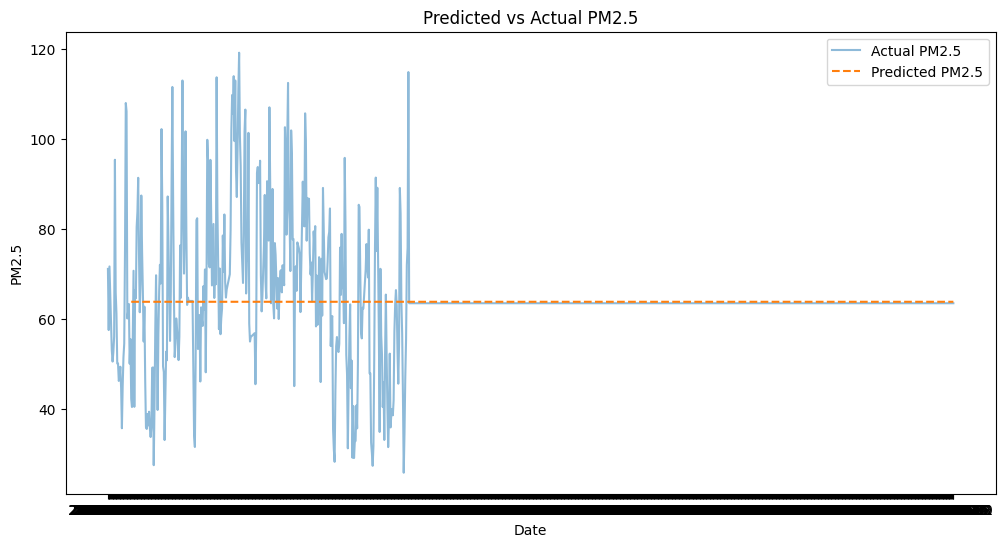

In [14]:
# Membuat generator data untuk prediksi
full_gen = TimeseriesGenerator(df_scaled, df_scaled[:, 6], length=lookback, batch_size=4)

# Melakukan prediksi
predictions = best_model.predict(full_gen)

# Membuat array nol dengan jumlah fitur yang sesuai untuk inverse_transform
num_features = len(features)  # Jumlah fitur yang digunakan saat normalisasi
dummy_array = np.zeros((len(predictions), num_features))  # Array nol dengan jumlah fitur yang sama
dummy_array[:, -1] = predictions.flatten()  # Menempatkan prediksi di kolom terakhir (PM2.5)

# Konversi kembali ke skala aslinya
pm25_predictions = scaler.inverse_transform(dummy_array)[:, -1]

# Membuat DataFrame hasil prediksi
prediction_dates = df["datetime"][lookback:].reset_index(drop=True)
pred_df = pd.DataFrame({"datetime": prediction_dates, "Predicted PM2.5": pm25_predictions})

# Plot hasil prediksi vs aktual
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df["datetime"], df["ISPU PM2.5"], label="Actual PM2.5", alpha=0.5)
plt.plot(pred_df["datetime"], pred_df["Predicted PM2.5"], label="Predicted PM2.5", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("PM2.5")
plt.title("Predicted vs Actual PM2.5")
plt.legend()
plt.show()




In [15]:
df_results.to_csv("jakarta_gbk results.csv", index=False)

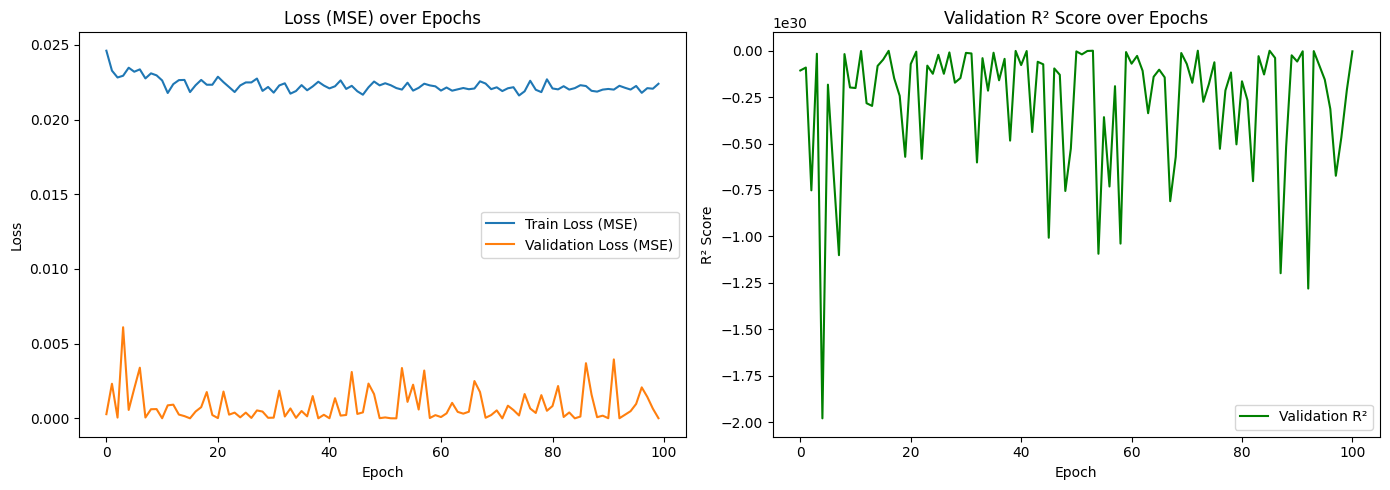

In [16]:
loss = best_history.history['loss']
val_loss = best_history.history['val_loss']
r2_scores = best_r2_callback.r2_scores

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss, label='Train Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss (MSE) over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(r2_scores, label='Validation R²', color='green')
plt.xlabel('Epoch')
plt.ylabel('R² Score')
plt.title('Validation R² Score over Epochs')
plt.legend()

plt.tight_layout()
plt.show()